The objective of this notebook is to apply the algos on ```ADMMAMA.py```. We will use the following __sintetic__ dataset: 

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from ADMMAMA import ADMMfullyconected, ADMMgeneral, AMA, built_edges

In [13]:
X_or = np.array([
    [1,1],
    [1,2],
    [2,1],
    [2,2]
])

X_ref = -X_or

X = np.vstack((X_or, X_ref))

We will use two weights matrices:

- fully conected but $$w_{ij} = \frac{1}{d_{ij}^2}$$ with $d_{ij}= ||x_i - x_j||_2$  

- Not fully conected: $$w_{ij} = l_{\{i,j\}}^{k}  \exp(- \phi d_{ij})$$ with $l_{\{i,j\}}^{k}$ es $1$ si $x_j$ esta entre los $k$ vecinos más cercanos de $x_i$. We set the coalescence $\phi$ to $\frac{1}{2}$ 

In [28]:
def fully_connected_w(X):

    D = cdist(X,X, 'euclidean')
    D = np.maximum(D, 1e-10)
    W = 1 / np.square(D)
    W = np.minimum(W, 1e10)  # Hacer la matriz simétrica
    np.fill_diagonal(W, 0)
    
    return W


def knn_w(X, k=3, phi=0.5):

    D = cdist(X,X, 'euclidean')
    np.fill_diagonal(D, np.inf)

    n = D.shape[0]
    W = np.zeros((n,n))

    for i in range(n): #Recorremos cada punto
        idx = np.argsort(D[i,:]) #Indices de los k vecinos más cercanos
        for j in idx[0:k]:  # skip the first one since it's the point itself
            W[i,j] = np.exp(-phi * D[i,j])

    W = np.maximum(W, W.T)  # Hacer la matriz simétrica
    
    return W

In [29]:
W_conn = fully_connected_w(X)
W_knn = knn_w(X, k=3, phi=0.5)

In [30]:
def plot_graph_weights(X, W, title):
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(X[:,0], X[:,1], c='steelblue', s=80, zorder=3)
    
    nonzero_W = W[W > 0]
    vmin, vmax = np.min(nonzero_W), np.max(nonzero_W)
    
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            if W[i,j] > 0:
                plt.plot(
                    [X[i,0], X[j,0]],
                    [X[i,1], X[j,1]],
                    color=plt.cm.plasma((W[i,j]-vmin)/(vmax-vmin)),
                    linewidth=2.5 * (W[i,j]/vmax),
                    alpha=0.9
                )
    
    # Etiquetas de nodos
    for i, (x, y) in enumerate(X):
        plt.text(x+0.05, y+0.05, f"{i}", fontsize=11, color="black")

    sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = plt.colorbar(sm, ax = ax)
    cbar.set_label('Edge Weights', rotation=270, labelpad=15)

    ax.set_title(title)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.grid(True, linestyle='--', alpha=0.3)
    plt.show()


Visualitiations:

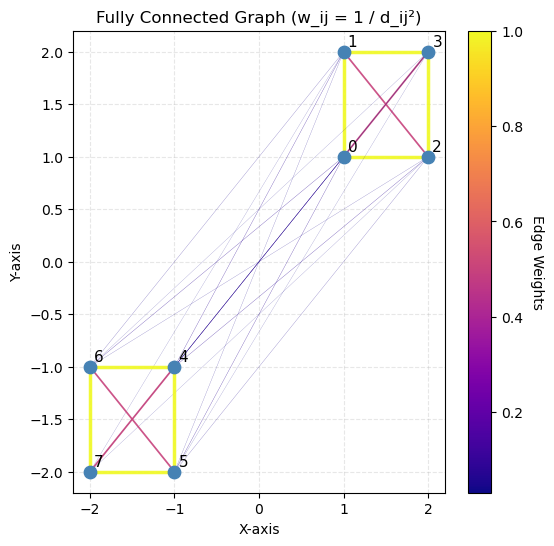

In [31]:
plot_graph_weights(X, W_conn, "Fully Connected Graph (w_ij = 1 / d_ij²)")

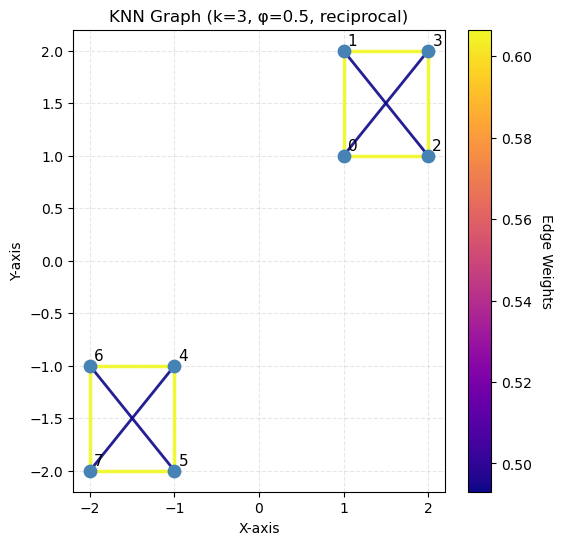

In [18]:
plot_graph_weights(X, W_knn,  "KNN Graph (k=3, φ=0.5, reciprocal)")

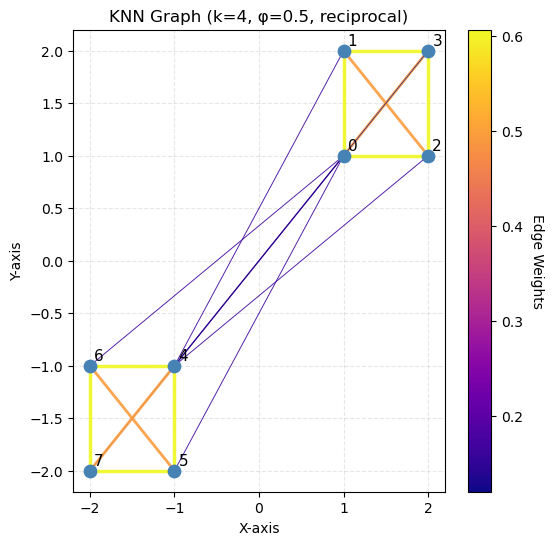

In [19]:
W_knn_4 = knn_w(X, k=4, phi=0.5)
plot_graph_weights(X, W_knn_4,  "KNN Graph (k=4, φ=0.5, reciprocal)")

We see that the knn method gives more relevance to the clusters while the connected method puts more relevance on the geometry of the data (?).

Now we will apply the algos:

In [37]:
from pyproximal import L1, L2, L0

def proximal(x,sigma, tau, norm_type):
    """
    Compute the proximal operator for a given norm.
    
    Parameters:
        x: Input vector.
        coef: Coefficient for the norm.
        tau: Coefficient for the proximal operator.
        norm_type: Type of norm ('L1', 'L2', 'L0').
    """
    if norm_type == 'L1':
        l1 = L1(sigma=sigma)
        return l1.prox(x, tau)
    elif norm_type == 'L2':
        l2 = L2(sigma=sigma)
        return l2.prox(x, tau)
    elif norm_type == 'L0':
        l0 = L0(sigma=sigma)
        return l0.prox(x, tau)
    else:
        raise ValueError("Invalid norm type. Choose 'L1', 'L2', or 'L0'.")   


In [ ]:
def ADMMfullyconected(X,gamma,W = None, nu = 1,
                      max_iter = 1000, tol = 1e-5,
                      norm_type = 'L2', verbose = False):
    """
    ADMM algorithm for convex clustering with fully connected graph.
    Parameters:
        X: Data matrix.
        gamma: Regularization parameter.
        W: Weight matrix.
        nu: Augmented Lagrangian parameter.
        max_iter: Maximum number of iterations.
        tol: Tolerance for convergence.
        norm_type: Type of norm for proximal operator.
        verbose: If True, print progress.
    Returns:
        U: Clustered data matrix.
        V: Auxiliary variable matrix.
        lambda: Lagrange multipliers.
        history: Convergence history.
    """
    p, n = X.shape
    # Edges list and weights:
    edges = [(i,j) for i in range(n) for j in range(i+1,n)]
    m = len(edges)
    if W is None:
        weights = np.ones(m)
    else:
        weights = np.array([W[i,j] for (i,j) in edges], dtype=np.float64)

    # Initialize variables
    V = np.zeros((p, m))
    lambda_ = np.zeros((p, m))

    history = {'primal_residual': [], 'obj': []}

    # Precompute mean of data
    xbar = np.mean(X, axis=1, keepdims=True)

    for it in range(1, max_iter+1):
        Y = X.copy()
        # Compute yi
        for idx, (i,j) in enumerate(edges):
            vt = lambda_[:,idx] + nu*V[:,idx]
            Y[:,i] += vt
            Y[:,j] -= vt

        # Update U
        U = (1/(1 + n*nu))*Y + (n*nu/(1 + n*nu))*np.repeat(xbar, n, axis=1)

        # Update V
        for idx, (i,j) in enumerate(edges):
            diff = U[:,i] - U[:,j] - (1/nu)*lambda_[:,idx]
            V[:,idx] = proximal(diff, 1, gamma*weights[idx]/nu, norm_type)
            lambda_[:,idx] += nu*(V[:,idx] - U[:,i] + U[:,j])
            

        primal_sq = 0
        for idx, (i,j) in enumerate(edges):
            res = V[:,idx]-U[:,i] + U[:,j]  
            primal_sq += np.sum(res**2)
        primal_residual = np.sqrt(primal_sq)
        history['primal_residual'].append(primal_residual)


                # optional objective (expensive for large n)
        fit = 0.5 * np.sum((X - U)**2)
        pen = 0.0
        for idx, (i, j) in enumerate(edges):
            pen += weights[idx] * np.linalg.norm(U[:, i] - U[:, j])
        history['obj'].append(fit + gamma * pen)

        if verbose and (it == 1 or it % 50 == 0):
            print(f"it {it:4d} | primal_res {primal_residual:.3e} | obj {history['obj'][-1]:.6f}")

        if primal_residual < tol:
            if verbose:
                print(f"Converged at iter {it}: primal_res={primal_residual:.2e}")
            break

    return U, V, lambda_, history

In [90]:
Uno = np.ones_like(W_conn)
Uno

array([[1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.]])

In [100]:
X = X.astype(float)

U_ADMM, V_ADMM, lambda_ADMM, history  = ADMMfullyconected(X, gamma= 10, W=Uno,
                                                          nu = 8, max_iter= 1000, tol =1e-4,
                                                          norm_type='L2',verbose=True)

it    1 | primal_res 6.536e-02 | obj 2.062284
Converged at iter 13: primal_res=5.65e-05


In [101]:
print(f"Primal Residual: {history['primal_residual'][:10]}")
print(f"Objective: {history['obj'][:10]}")
print(f"Norm of V_ADMM: {np.linalg.norm(V_ADMM,axis=0)}")

Primal Residual: [0.06535947712418322, 0.036310820624545936, 0.02017267812474799, 0.011207043402637673, 0.0062261352236876455, 0.0034589640131597044, 0.0019216466739777616, 0.0010675814855429788, 0.0005931008253017289, 0.0003295004585008865]
Objective: [2.062283737024222, 2.0623215777328716, 2.06237530219577, 2.062415242282251, 2.0624405463928417, 2.0624555657054096, 2.0624642065189818, 2.06246909856079, 2.062471844630262, 2.062473378949247]
Norm of V_ADMM: [0.11759056]


In [102]:
U_ADMM

array([[ 1.        ,  1.        ],
       [ 1.47750267,  1.5363262 ],
       [ 1.52249733,  1.4636738 ],
       [ 2.        ,  2.        ],
       [-1.        , -1.        ],
       [-1.47750267, -1.5363262 ],
       [-1.52249733, -1.4636738 ],
       [-2.        , -2.        ]])

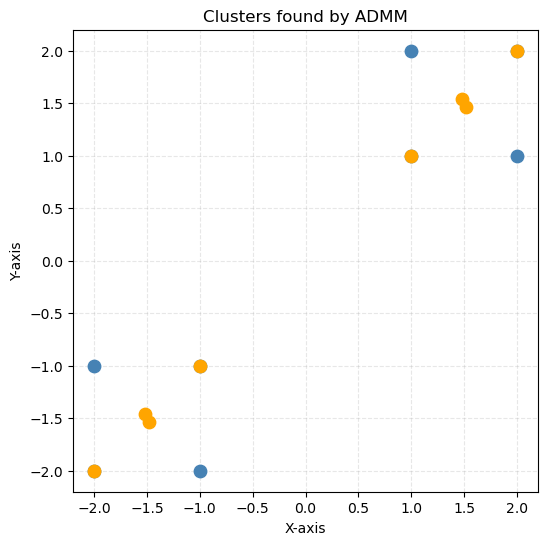

In [103]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X[:,0], X[:,1], c='steelblue', s=80, zorder=3)
ax.scatter(U_ADMM[:,0], U_ADMM[:,1], c='orange', s=80, zorder=3)

ax.set_title("Clusters found by ADMM")
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.grid(True, linestyle='--', alpha=0.3)
plt.show()

In [24]:
U_ADMM_2, V_ADMM, lambda_ADMM, history  = ADMMfullyconected(X, gamma= 10, W=W_knn,
                                                          nu = 8, max_iter= 1000, tol =0,
                                                          norm_type='L2',verbose=True)

it    1 | primal_res 5.073e-02 | obj 1.599379
it   50 | primal_res 0.000e+00 | obj 1.487725
it  100 | primal_res 0.000e+00 | obj 1.487725
it  150 | primal_res 0.000e+00 | obj 1.487725
it  200 | primal_res 0.000e+00 | obj 1.487725
it  250 | primal_res 0.000e+00 | obj 1.487725
it  300 | primal_res 0.000e+00 | obj 1.487725
it  350 | primal_res 0.000e+00 | obj 1.487725
it  400 | primal_res 0.000e+00 | obj 1.487725
it  450 | primal_res 0.000e+00 | obj 1.487725
it  500 | primal_res 0.000e+00 | obj 1.487725
it  550 | primal_res 0.000e+00 | obj 1.487725
it  600 | primal_res 0.000e+00 | obj 1.487725
it  650 | primal_res 0.000e+00 | obj 1.487725
it  700 | primal_res 0.000e+00 | obj 1.487725
it  750 | primal_res 0.000e+00 | obj 1.487725
it  800 | primal_res 0.000e+00 | obj 1.487725
it  850 | primal_res 0.000e+00 | obj 1.487725
it  900 | primal_res 0.000e+00 | obj 1.487725
it  950 | primal_res 0.000e+00 | obj 1.487725
it 1000 | primal_res 0.000e+00 | obj 1.487725


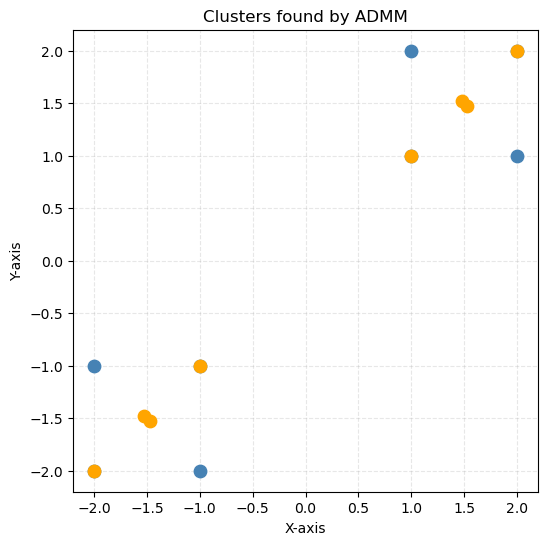

In [25]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X[:,0], X[:,1], c='steelblue', s=80, zorder=3)
ax.scatter(U_ADMM_2[:,0], U_ADMM_2[:,1], c='orange', s=80, zorder=3)

ax.set_title("Clusters found by ADMM")
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.grid(True, linestyle='--', alpha=0.3)
plt.show()

In [26]:
edges = built_edges(W_knn)


In [27]:
edges

([(0, 1),
  (0, 2),
  (0, 3),
  (1, 2),
  (1, 3),
  (2, 3),
  (4, 5),
  (4, 6),
  (4, 7),
  (5, 6),
  (5, 7),
  (6, 7)],
 array([0.60653066, 0.60653066, 0.49306869, 0.49306869, 0.60653066,
        0.60653066, 0.60653066, 0.60653066, 0.49306869, 0.49306869,
        0.60653066, 0.60653066]))

In [21]:
weights

[0.6065306597126334,
 0.6065306597126334,
 0.4930686913952398,
 0.4930686913952398,
 0.6065306597126334,
 0.6065306597126334,
 0.6065306597126334,
 0.6065306597126334,
 0.4930686913952398,
 0.4930686913952398,
 0.6065306597126334,
 0.6065306597126334]

In [23]:
edges = built_edges(W_knn)

weights = [W_knn[i,j] for (i,j) in edges[0]]


U, V, lambda_ = ADMMgeneral(X, edges[0], edges[1], gamma = 10, nu=8,
                max_iter=1000, tol=1e-5,
                norm_type='L2', verbose=False)

ValueError: row index exceeds matrix dimensions